In [1]:
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x)
train_y = Variable(torch.sin(((train_x.data[:, 0] + train_x.data[:, 1]) * (2 * math.pi))))

In [3]:
class KissGPModel(gpytorch.GPModel):
    def __init__(self):
        super(KissGPModel, self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        covar_module = RBFKernel(log_lengthscale_bounds=(-3, 5))
        self.grid_covar_module = GridInterpolationKernel(covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-1, 1))
        self.initialize_interpolation_grid(20, grid_bounds=[(0, 1), (0, 1)])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)
    
model = KissGPModel()

In [4]:
def plot_model_and_predictions(model):
    n = 10
    test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
    for i in range(n):
        for j in range(n):
            test_x.data[i * n + j][0] = float(i) / (n-1)
            test_x.data[i * n + j][1] = float(j) / (n-1)

    observed_pred = model(test_x)
    pred_labels = observed_pred.mean().view(n, n).data.numpy()
    
    test_y_actual = torch.sin(((test_x.data[:, 0] + test_x.data[:, 1]) * (2 * math.pi))).numpy().reshape(n, n)
    delta_y = numpy.absolute(pred_labels - test_y_actual)
    
    def ax_plot(f, ax, y_labels, title):
        im = ax.imshow(y_labels)
        ax.set_title(title)
        f.colorbar(im)
    
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')
    
    f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

    f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')
    
    return f

In [5]:
model.condition(train_x, train_y)

# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(60):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/60 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

/Users/gpleiss/Dropbox/workspace/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/60 - Loss: 1730.058
Iter 2/60 - Loss: 1649.853
Iter 3/60 - Loss: 1578.048
Iter 4/60 - Loss: 1509.847
Iter 5/60 - Loss: 1426.100
Iter 6/60 - Loss: 1349.149
Iter 7/60 - Loss: 1274.195
Iter 8/60 - Loss: 1185.641
Iter 9/60 - Loss: 1094.067
Iter 10/60 - Loss: 991.770
Iter 11/60 - Loss: 885.175
Iter 12/60 - Loss: 770.109
Iter 13/60 - Loss: 664.117
Iter 14/60 - Loss: 552.352
Iter 15/60 - Loss: 455.386
Iter 16/60 - Loss: 349.586
Iter 17/60 - Loss: 269.321
Iter 18/60 - Loss: 182.674
Iter 19/60 - Loss: 88.150
Iter 20/60 - Loss: 11.944
Iter 21/60 - Loss: -63.975
Iter 22/60 - Loss: -154.133
Iter 23/60 - Loss: -253.202
Iter 24/60 - Loss: -320.878
Iter 25/60 - Loss: -391.441
Iter 26/60 - Loss: -476.771
Iter 27/60 - Loss: -552.672
Iter 28/60 - Loss: -635.492
Iter 29/60 - Loss: -712.757
Iter 30/60 - Loss: -787.313
Iter 31/60 - Loss: -867.543
Iter 32/60 - Loss: -943.704
Iter 33/60 - Loss: -1032.135
Iter 34/60 - Loss: -1094.066
Iter 35/60 - Loss: -1179.448
Iter 36/60 - Loss: -1254.768
Iter 37/60 

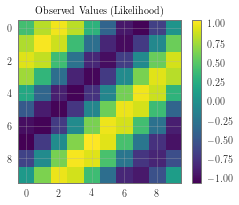

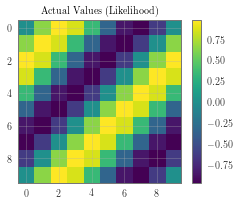

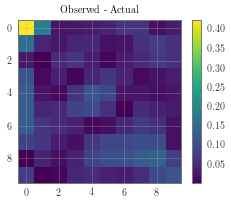

In [6]:
f = plot_model_and_predictions(model)